In [51]:
%matplotlib inline

import fiona
import rasterio
from rasterio.tools.mask import mask
import numpy as np
import pandas as pd
import progressbar
import os 

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm

import itertools
from collections import deque

import scipy.stats
import scipy.spatial.distance

from haversine import haversine

import Data, Figures, Models

Data = reload(Data)
Figures = reload(Figures)
Models = reload(Models)

figureOutputDir = "/home/caleb/Dropbox/CalebBistra/MyPapers/PNAS_2016/figures/"

In [2]:
shapefile = fiona.open("data/countyBoundaries/countyBoundaries2.shp", "r")
counties = list(shapefile)
shapefile.close()

src = rasterio.open("data/usRaster.tif")
noData = src.nodatavals
data = src.read()
src.close()

# rasterio returns a 3-dimensional array of shape (1,width,height), we need to remove the first axis to visualize
data = data.squeeze()

In [3]:
startSeaLevelRise = 0
stopSeaLevelRise = 10
seaLevelRiseRange = range(startSeaLevelRise,stopSeaLevelRise+1)

startYear = 2013
stopYear = 2013
yearRange = range(startYear,stopYear+1)


populationDataSets, migrationDataSets = Data.loadMigrationPopulationDataset(yearRange, zeroSelfMigration=False)
        
countyIds = Data.loadCounties()
countyIdMap = {countyId:i for i,countyId in enumerate(countyIds)} #mapping from countyId to position in list
countyIndex_IdMap = {i:countyId for i,countyId in enumerate(countyIds)}
countyNameMapping = Data.loadCountyNameMap() #mapping from countyId to name

originalCentroids = Data.loadCountyCentroids()
distanceMatrix = Data.loadCountyPairwiseDistanceMatrix()

Loading the distance matrix


In [25]:
countyPopulationAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyLandAmountAffected = [] # 1 dictionary for each number in seaLevelRiseRange
countyTotalLand = []
percentLandAffected = []
newCentroids = []

countyNames = dict()
goodCounties = set()

bar = progressbar.ProgressBar()
for x in bar(seaLevelRiseRange):

    tempCountyPopulationAffected = dict()
    tempCountyLandAmountAffected = dict()
    tempCountyTotalLand = dict()
    tempCentroids = dict()
    totalLand = 0.0
    
    for county in counties:
        
        countyId = int(county["properties"]['GEOID'])
        countyName = countyNameMapping[countyId]
        if countyId in countyIds:
            try:
                geoms = [county["geometry"]]

                #src = rasterio.open("usRaster.tif")
                src = rasterio.open("outputs/mask_%d.tif" % (x))
                out_image, out_transform = mask(src, geoms, crop=True, nodata=-999)
                src.close()

                numZero = np.sum(out_image == -999.0)
                numAffected = np.sum(out_image == 1) #we marked raster as 1 if it was reachable by sea level rise
                numNotAffected = np.sum(out_image == 0)

                if x==0:
                    numNotAffected+=numAffected
                    numAffected=0
                
                assert numZero + numAffected + numNotAffected == out_image.count()

                #-----------------------------------
                #Calculate mean location of affected pixels
                if numAffected==0:
                    tempCentroids[countyId] = (0.0,0.0)
                else:
                    out_image = out_image.squeeze()
                    coords = np.array(np.where(out_image==1)) #find flooded pixels locations
                    centroid = np.mean(coords,axis=1) #average flooded pixel locations
                    centroid = np.round(centroid) 
                    centroid = out_transform * (centroid[1], centroid[0]) #project to lat/lon
                    tempCentroids[countyId] = (centroid[1], centroid[0]) #save values
                #-----------------------------------
                
                totalNum = numAffected+numNotAffected

                percentAffected = (numAffected) / float(totalNum)
                totalLand += numAffected

                tempCountyPopulationAffected[countyId] = percentAffected
                tempCountyLandAmountAffected[countyId] = numAffected
                tempCountyTotalLand[countyId] = totalNum

                countyNames[countyId] = countyName
                goodCounties.add(countyId)
            except ValueError as e:
                pass
    
    #-----------------------------------
    #Convert centroid dict to list
    tempNewCentroids = []
    for k,countyId in enumerate(countyIds):
        if countyId in tempCentroids:
            tempNewCentroids.append(tempCentroids[countyId])
        else:
            tempNewCentroids.append((0.0,0.0))
    #-----------------------------------
    
    countyPopulationAffected.append(tempCountyPopulationAffected) #TODO: fix this to be dict
    countyLandAmountAffected.append(tempCountyLandAmountAffected)
    countyTotalLand.append(tempCountyTotalLand)
    newCentroids.append(tempNewCentroids)

100% (11 of 11) |##############################################################################################################################################################| Elapsed Time: 0:01:02 Time: 0:01:02


In [26]:
print newCentroids[3][countyIdMap[12086]]

(25.425000000000001, -80.38333333333334)


## Visualize Centroids for a Particular County

SLR: 2 meters
25.341667, -80.425000


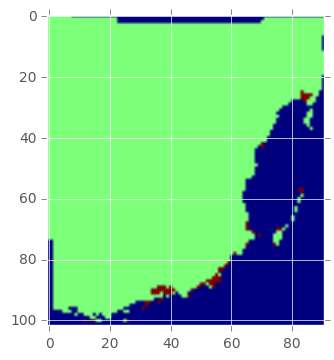

SLR: 3 meters
25.425000, -80.383333


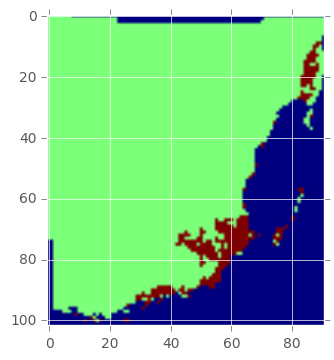

In [5]:
interestedFips = 12086 #12086 is Miami-Dade
VISUALIZE_CENTROID = False
centroidRadius = 2
seaLevelRiseRangeTemp = range(2,4)

for x in seaLevelRiseRangeTemp:

    print "SLR: %d meters" % (x)

    county = [_ for _ in counties if int(_["properties"]['GEOID'])==interestedFips][0]
    
    countyId = int(_["properties"]['GEOID'])
    countyName = countyNameMapping[countyId]
   
    geoms = [county["geometry"]]

    src = rasterio.open("outputs/mask_%d.tif" % (x))
    out_image, out_transform = mask(src, geoms, crop=True, nodata=-999)
    src.close()
    
    out_image = out_image.squeeze()
    coords = np.array(np.where(out_image==1))
    centroid = np.mean(coords,axis=1)
    centroid = np.round(centroid)
    
    if VISUALIZE_CENTROID:
        for _ in range(-centroidRadius,centroidRadius+1):
            for __ in range(-centroidRadius,centroidRadius+1):
                out_image[centroid[0]+_,centroid[1]+__] = 2
    
    t_coord = out_transform * (centroid[1], centroid[0])
    print "%0f, %0f" % (t_coord[1],t_coord[0])
    
    
    out_image[out_image == -999.0] = -1
    plt.figure()
    plt.imshow(out_image.squeeze())
    plt.show()
    

    numZero = np.sum(out_image == -999.0)
    numAffected = np.sum(out_image == 1)
    numNotAffected = np.sum(out_image == 0)

## Radiation Model Fit Parameters

In [6]:
fitParameters = [] #one for each year

for i,year in enumerate(yearRange):
    print "Calculating num migrants by population fit for %d" % (year)
    
    popVals = []
    exteriorMigrants = []
    interiorMigrants = []
    for j,countyId in enumerate(countyIds):
        popVals.append(populationDataSets[i][j])
        exteriorMigrants.append(np.sum(migrationDataSets[i][j,:])-migrationDataSets[i][j,j])
        interiorMigrants.append(migrationDataSets[i][j,j])
        
    popVals = np.array(popVals)
    exteriorMigrants = np.array(exteriorMigrants)
    interiorMigrants = np.array(interiorMigrants)

    alpha = np.polyfit(popVals, exteriorMigrants, 1)[0]
    beta = np.polyfit(popVals, interiorMigrants, 1)[0]
    
    print alpha,beta
    
    fitParameters.append([alpha,beta])

Calculating num migrants by population fit for 2013
0.0313670997746 0.785373267073


## Radiation Model Unconstrained

In [64]:
def radiationModelWrapper(populationData, distanceMatrix, floodedPercentages, unfloodedCentroids, floodedCentroids,
                          alpha=0.03, verbose=False):
    '''Run multi-step radiation model
    '''
    
    #print len(populationData)
    #print distanceMatrix.shape
    #print len(floodedPercentages)
    #print len(unfloodedCentroids)
    #print len(floodedCentroids)
    
    #Step 1.) Calculate the unflooded population for each county and run radiation model for unflooded*unflooded
    if verbose: print "\t1.)Running the unflooded * unflooded radiation model step"
    unfloodedPopulation = []
    for i in xrange(len(populationData)):
        unfloodedPop = populationData[i] * float(1-floodedPercentages[i])
        unfloodedPopulation.append(unfloodedPop)
        
    A = radiationModelNormalized(unfloodedPopulation, unfloodedPopulation, distanceMatrix,
                                 alpha=alpha, considerClosest=False) #No self migrations allowed
    
    #Step 2.) Find which counties are flooded and calculate the flooded populations
    if verbose: print "\t2.)Running the flooded * unflooded radiation model step"
    floodedPopulation = []
    for i in xrange(len(populationData)):
        floodedPop = populationData[i] * float(floodedPercentages[i])
        floodedPopulation.append(floodedPop)
    #Step 3.) Calculate distances between flooded county centroids and unflooded centroids
    if verbose: print "\t3.)Calculating modified distance matrix"
    modifiedDistanceMatrix = scipy.spatial.distance.cdist(floodedCentroids,unfloodedCentroids,haversine)
    
    #Step 4.) Run the flooded by unflooded radiation model
    if verbose: print "\t4.)Running the unflooded * flooded radiation model step"
    B = radiationModelNormalized(floodedPopulation, unfloodedPopulation, modifiedDistanceMatrix, 
                                 alpha=1.0, considerClosest=True)

    return A,B
    
def radiationModelNormalized(populationDataOrigins, populationDataDestinations, distanceMatrix, 
                             alpha, considerClosest=False):
    '''Let n = |populationDataOrigins|, m = |populationDataDestinations|
    
    This method will return an n*m od matrix, T, where an entry, T_{ij} represents the number of migrations from
    the i^{th} origin to the j^{th} destination as calculated by the radiation model:
    
    T_{ij} = \alpha m_i * \frac{m_i * m_j}{(m_i + s_{ij})(m_i + m_j + s_{ij})}
    
    Note: the migration probabilities (i.e. \frac{m_i * m_j}{(m_i + s_{ij})(m_i + m_j + s_{ij})}) are row normalized
    s.t. each row sums to 1. This makes them a probability distribution that assigns a certain percentage of the 
    origin migrating population \alpha m_i to each destination.
    
    The distance matrix, D, should be an n*m matrix where an entry, D_{ij} is the distance between
    the i^{th} origin and j^{th} destination locations.
    
    alpha is a scalar that describes the percentage of the population that will migrate in each case.
    '''
    n = len(populationDataOrigins)
    m = len(populationDataDestinations)
    
    migratingPopulations = np.array([alpha*pop for pop in populationDataOrigins])
    probabilityMatrix = np.zeros((n, m))
    
    for i in xrange(n):
    
        #Step 1.) Sort destination locations by distance (closest to farthest away)
        otherPatches = []
        for j in xrange(m):
            otherPatches.append((distanceMatrix[i][j], j))
        otherPatches.sort(key=lambda x: x[0])
        
        if not considerClosest: #if origins != destinations then we need to look at the i==j case
            otherPatches = otherPatches[1:]
        
        #Step 2.) Incrementally calculate the probabilities to migrate to other counties
        originPopulation = float(populationDataOrigins[i])
        
        S = 0
        for distance, j in otherPatches:
            destinationPopulation = float(populationDataDestinations[j])
            
            numerator = originPopulation * destinationPopulation
            denominator = (originPopulation + S) * (originPopulation + destinationPopulation + S)
            
            if denominator!=0:
                total = (numerator / denominator)
            else:
                total = 0.0

            probabilityMatrix[i,j] = float(total)
            S += destinationPopulation
            
    assert migratingPopulations.shape[0] == probabilityMatrix.shape[0]
    
    #Step 3.) Normalize probabilityMatrix such that rows sum to 1
    rowSums = np.sum(probabilityMatrix,axis=1)
    newProbabilities = (probabilityMatrix.T/rowSums).T
    
    #Step 4.) Multiply the outgoing population for each county across its row
    odMigrationMatrix = (newProbabilities.T * migratingPopulations).T

    return odMigrationMatrix

## Run our new "multi-step" radiation model

In [65]:
seaLevelRiseRangeTemp = range(0,4)

radiationOutputs = []

for i,year in enumerate(yearRange):
    print "Running multi-step radiation model for year %d" % (year)
    print "-" * 80
    
    slrRadiationOutputs = []
    alpha,beta = fitParameters[i]
    
    for j,x in enumerate(seaLevelRiseRangeTemp):
        print "Running model for SLR: %d" % (x)

                
        floodedPercentages = []
        for k,countyId in enumerate(countyIds):
            if countyId in countyPopulationAffected[j]:
                floodedPercentages.append(countyPopulationAffected[j][countyId])
            else:
                floodedPercentages.append(0)
        
        population = []
        for k,countyId in enumerate(countyIds):
            population.append(populationDataSets[i][k])
            
        floodedCentroids = newCentroids[j]

        #print all([(floodedCentroids[z][0]==0 and floodedCentroids[z][0]==0) for z in range(len(floodedCentroids))])
        
        T,T_prime = radiationModelWrapper(population, distanceMatrix, floodedPercentages, originalCentroids, floodedCentroids, alpha, verbose=True)
        slrRadiationOutputs.append((T,T_prime))
    radiationOutputs.append(slrRadiationOutputs)

print "Done"

Running multi-step radiation model for year 2013
--------------------------------------------------------------------------------
Running model for SLR: 0
	1.)Running the unflooded * unflooded radiation model step
	2.)Running the flooded * unflooded radiation model step
	3.)Calculating modified distance matrix
	4.)Running the unflooded * flooded radiation model step
Running model for SLR: 1
	1.)Running the unflooded * unflooded radiation model step
	2.)Running the flooded * unflooded radiation model step
	3.)Calculating modified distance matrix
	4.)Running the unflooded * flooded radiation model step
Running model for SLR: 2
	1.)Running the unflooded * unflooded radiation model step
	2.)Running the flooded * unflooded radiation model step
	3.)Calculating modified distance matrix
	4.)Running the unflooded * flooded radiation model step
Running model for SLR: 3
	1.)Running the unflooded * unflooded radiation model step
	2.)Running the flooded * unflooded radiation model step
	3.)Calculat

## Brief Sanity Check

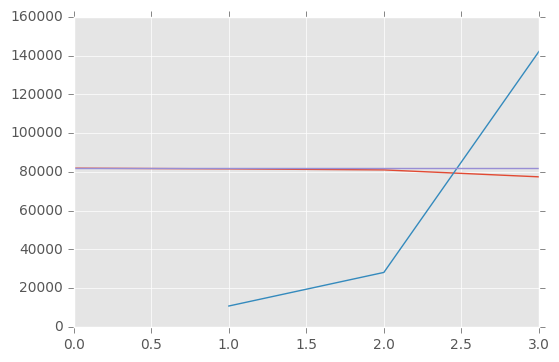

In [79]:
interestedFips = 12086
interestedId = countyIdMap[interestedFips]

xVals = []
yVals1 = []
yVals2 = []
popVals = []
affectedPopulationVals = []

for i,x in enumerate(seaLevelRiseRangeTemp):
    T,S = radiationOutputs[0][x]
    
    xVals.append(x)
    yVals1.append(np.sum(T[interestedId,:]))
    yVals2.append(np.sum(S[interestedId,:]))
    popVals.append(alpha*float(populationDataSets[0][interestedId]))
    #affectedPopulationVals.append(countyPopulationAffected[x][interestedFips]*float(populationDataSets[0][interestedId]))

plt.figure()
plt.plot(xVals,yVals1)
plt.plot(xVals,yVals2)
plt.plot(xVals,popVals)
#plt.plot(xVals,affectedPopulationVals)
plt.show()